# Quality control reporting for optimization of AGP and Mito channels

## Import libraries

In [1]:
# Load necessary packages
suppressPackageStartupMessages({
    library(arrow)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(colorspace)
})

Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘colorspace’ was built under R version 4.2.3”


## Set up directory for plots

In [2]:
# Set up directory for plots
figures_dir <- "../qc_figures"

# Create the directory if it doesn't exist
if (!dir.exists(figures_dir)) {
    dir.create(figures_dir)
}

## Load in the QC results 

In [3]:
# Load the dataframe from a path
qc_results_df <- read_parquet("../qc_results/NF0017_qc_results_optimization.parquet")

# Check for any NaNs in the columns starting with Metadata_
metadata_cols <- grep("^Metadata_", colnames(qc_results_df), value = TRUE)
na_counts <- sapply(qc_results_df[metadata_cols], function(x) sum(is.na(x)))

# Print the count of NaNs for each Metadata_ column
na_counts

# Look at the dimensions and head of the dataframe
dim(qc_results_df)
head(qc_results_df)

Metadata_Plate   Metadata_Well   Metadata_Site Metadata_Zslice 
              0               0               0               0

[1] 1182   10

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,AGP_conditions,Mito_conditions,Blurry_Mito,Blurry_AGP,Saturated_Mito,Saturated_AGP
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
NF0017,C5,1,ZS000,10-115,24-350,FALSE,FALSE,FALSE,FALSE
NF0017,C5,1,ZS001,10-115,24-350,FALSE,FALSE,FALSE,FALSE
NF0017,C5,1,ZS002,10-115,24-350,FALSE,FALSE,FALSE,FALSE
NF0017,C5,1,ZS003,10-115,24-350,FALSE,FALSE,FALSE,FALSE
NF0017,C5,1,ZS004,10-115,24-350,FALSE,FALSE,FALSE,FALSE
NF0017,C5,1,ZS005,10-115,24-350,FALSE,TRUE,TRUE,FALSE


## Melt dataframe to reduce columns

In [4]:
qc_type_cols <- grep("Blurry|Saturated", colnames(qc_results_df), value = TRUE)

# Assuming qc_results_df is your dataframe and condition_cols is a vector of column names
melted_qc_df <- qc_results_df %>%
  pivot_longer(
    cols = all_of(qc_type_cols),
    names_to = c("QC_type", "Channel"),
    names_sep = "_",
    values_to = "Failed"
  ) %>%
  mutate(
    Condition_combo = paste0("(", AGP_conditions, ")-(", Mito_conditions, ")")
  )

dim(melted_qc_df)
head(melted_qc_df)

[1] 4728   10

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,AGP_conditions,Mito_conditions,QC_type,Channel,Failed,Condition_combo
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
NF0017,C5,1,ZS000,10-115,24-350,Blurry,Mito,FALSE,(10-115)-(24-350)
NF0017,C5,1,ZS000,10-115,24-350,Blurry,AGP,FALSE,(10-115)-(24-350)
NF0017,C5,1,ZS000,10-115,24-350,Saturated,Mito,FALSE,(10-115)-(24-350)
NF0017,C5,1,ZS000,10-115,24-350,Saturated,AGP,FALSE,(10-115)-(24-350)
NF0017,C5,1,ZS001,10-115,24-350,Blurry,Mito,FALSE,(10-115)-(24-350)
NF0017,C5,1,ZS001,10-115,24-350,Blurry,AGP,FALSE,(10-115)-(24-350)


In [5]:
# Group by Well, Site, and Condition_combo and check if there is at least one failing z-slice
failed_condition_combos <- melted_qc_df %>%
  group_by(Metadata_Well, Metadata_Site, Condition_combo) %>%
  summarise(At_least_one_fail = any(Failed == TRUE), .groups = 'drop') %>%
  filter(At_least_one_fail == TRUE) %>%
  group_by(Metadata_Well, Metadata_Site) %>%
  summarise(Failed_condition_combos_count = n(), .groups = 'drop')

# Print the result
print(failed_condition_combos)

# A tibble: 4 × 3
  Metadata_Well Metadata_Site Failed_condition_combos_count
  <chr>                 <int>                         <int>
1 C5                        1                             6
2 C8                        3                             2
3 C9                        5                             6
4 C9                        6                             1


## Generate count per condition and channel

In [6]:
# Count unique AGP_condition and Mito_condition combinations
unique_combos_count <- melted_qc_df %>%
  distinct(Condition_combo) %>%
  summarise(Unique_combos = n())

# Print the number of unique combinations
print(unique_combos_count)

# Assuming melted_qc is your dataframe
count_failed_qc <- melted_qc_df %>%
  filter(Failed == TRUE) %>%
  group_by(Condition_combo, QC_type, Channel) %>%
  summarise(Failed_count = n(), .groups = 'drop')

dim(count_failed_qc)
count_failed_qc

# A tibble: 1 × 1
  Unique_combos
          <int>
1             6


[1] 15  4

Condition_combo,QC_type,Channel,Failed_count
<chr>,<chr>,<chr>,<int>
(10-115)-(24-350),Blurry,AGP,7
(10-115)-(24-350),Blurry,Mito,3
(10-115)-(24-350),Saturated,Mito,2
(14-115)-(29-350),Blurry,AGP,8
(14-115)-(29-350),Blurry,Mito,2
(14-115)-(29-350),Saturated,AGP,9
(14-115)-(29-350),Saturated,Mito,6
(5-115)-(19-250),Blurry,AGP,5
(5-115)-(19-250),Blurry,Mito,3


## Plot the count of failed z-slices across channel and condition

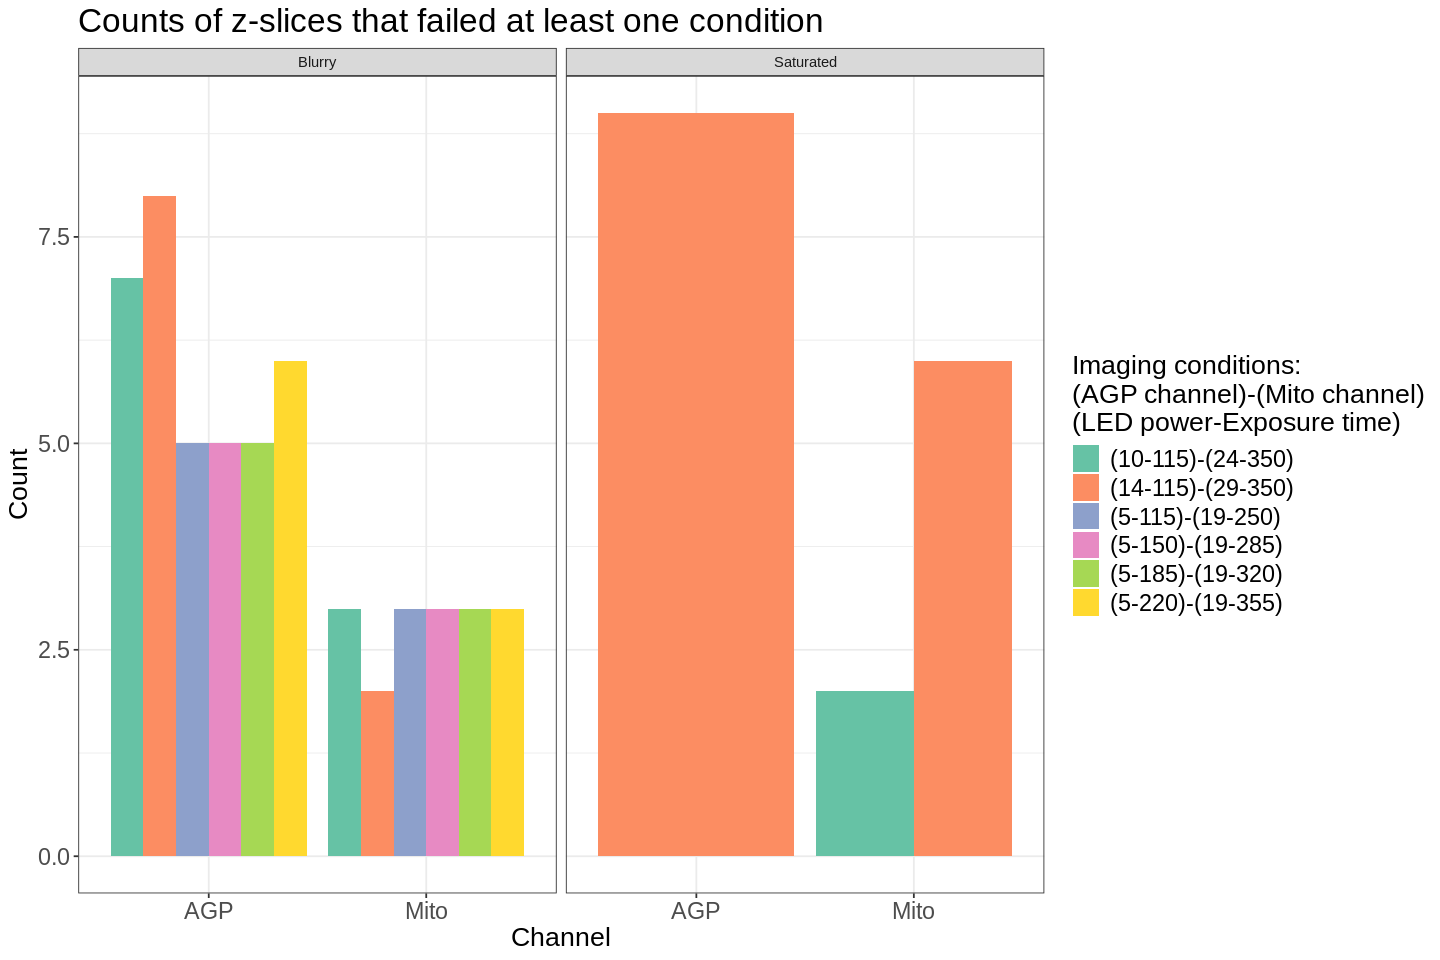

In [7]:
# Set width and height
width = 12
height = 8
options(repr.plot.width = width, repr.plot.height = height)

# Plot the bar chart of counts of failed z-slices for each condition and channel
count_zslices_channel <- ggplot(count_failed_qc, aes(x = Channel, y = Failed_count, fill = Condition_combo)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_brewer(palette = "Set2") +
    facet_grid(~QC_type) +
    labs(
        title = "Counts of z-slices that failed at least one condition",
        x = "Channel",
        y = "Count",
        fill = "Imaging conditions:\n(AGP channel)-(Mito channel)\n(LED power-Exposure time)"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)
    )

# Show plot
print(count_zslices_channel)

# Save plot
ggsave(file.path(figures_dir, "optimization_count_zslices_channel.png"), plot = count_zslices_channel, width = width, height = height, dpi = 500)


## Calculate number of z-slices failed per slice

In [8]:
# Group by Metadata_Zslice, Condition, and Channel, then summarize the number of failed zslices
failed_zslices_per_metadata <- melted_qc_df %>%
    group_by(Metadata_Zslice, QC_type, Channel, Condition_combo) %>%
    summarize(Failed_Count = sum(Failed == TRUE, na.rm = TRUE)) %>%  # Explicitly count TRUE values
    ungroup()

# Show dimension and head of the resulting dataframe
dim(failed_zslices_per_metadata)
head(failed_zslices_per_metadata)

`summarise()` has grouped output by 'Metadata_Zslice', 'QC_type', 'Channel'.
You can override using the `.groups` argument.


[1] 696   5

Metadata_Zslice,QC_type,Channel,Condition_combo,Failed_Count
<chr>,<chr>,<chr>,<chr>,<int>
ZS000,Blurry,AGP,(10-115)-(24-350),0
ZS000,Blurry,AGP,(14-115)-(29-350),0
ZS000,Blurry,AGP,(5-115)-(19-250),0
ZS000,Blurry,AGP,(5-150)-(19-285),0
ZS000,Blurry,AGP,(5-185)-(19-320),0
ZS000,Blurry,AGP,(5-220)-(19-355),0


## Plot the failed counts across each z-slice

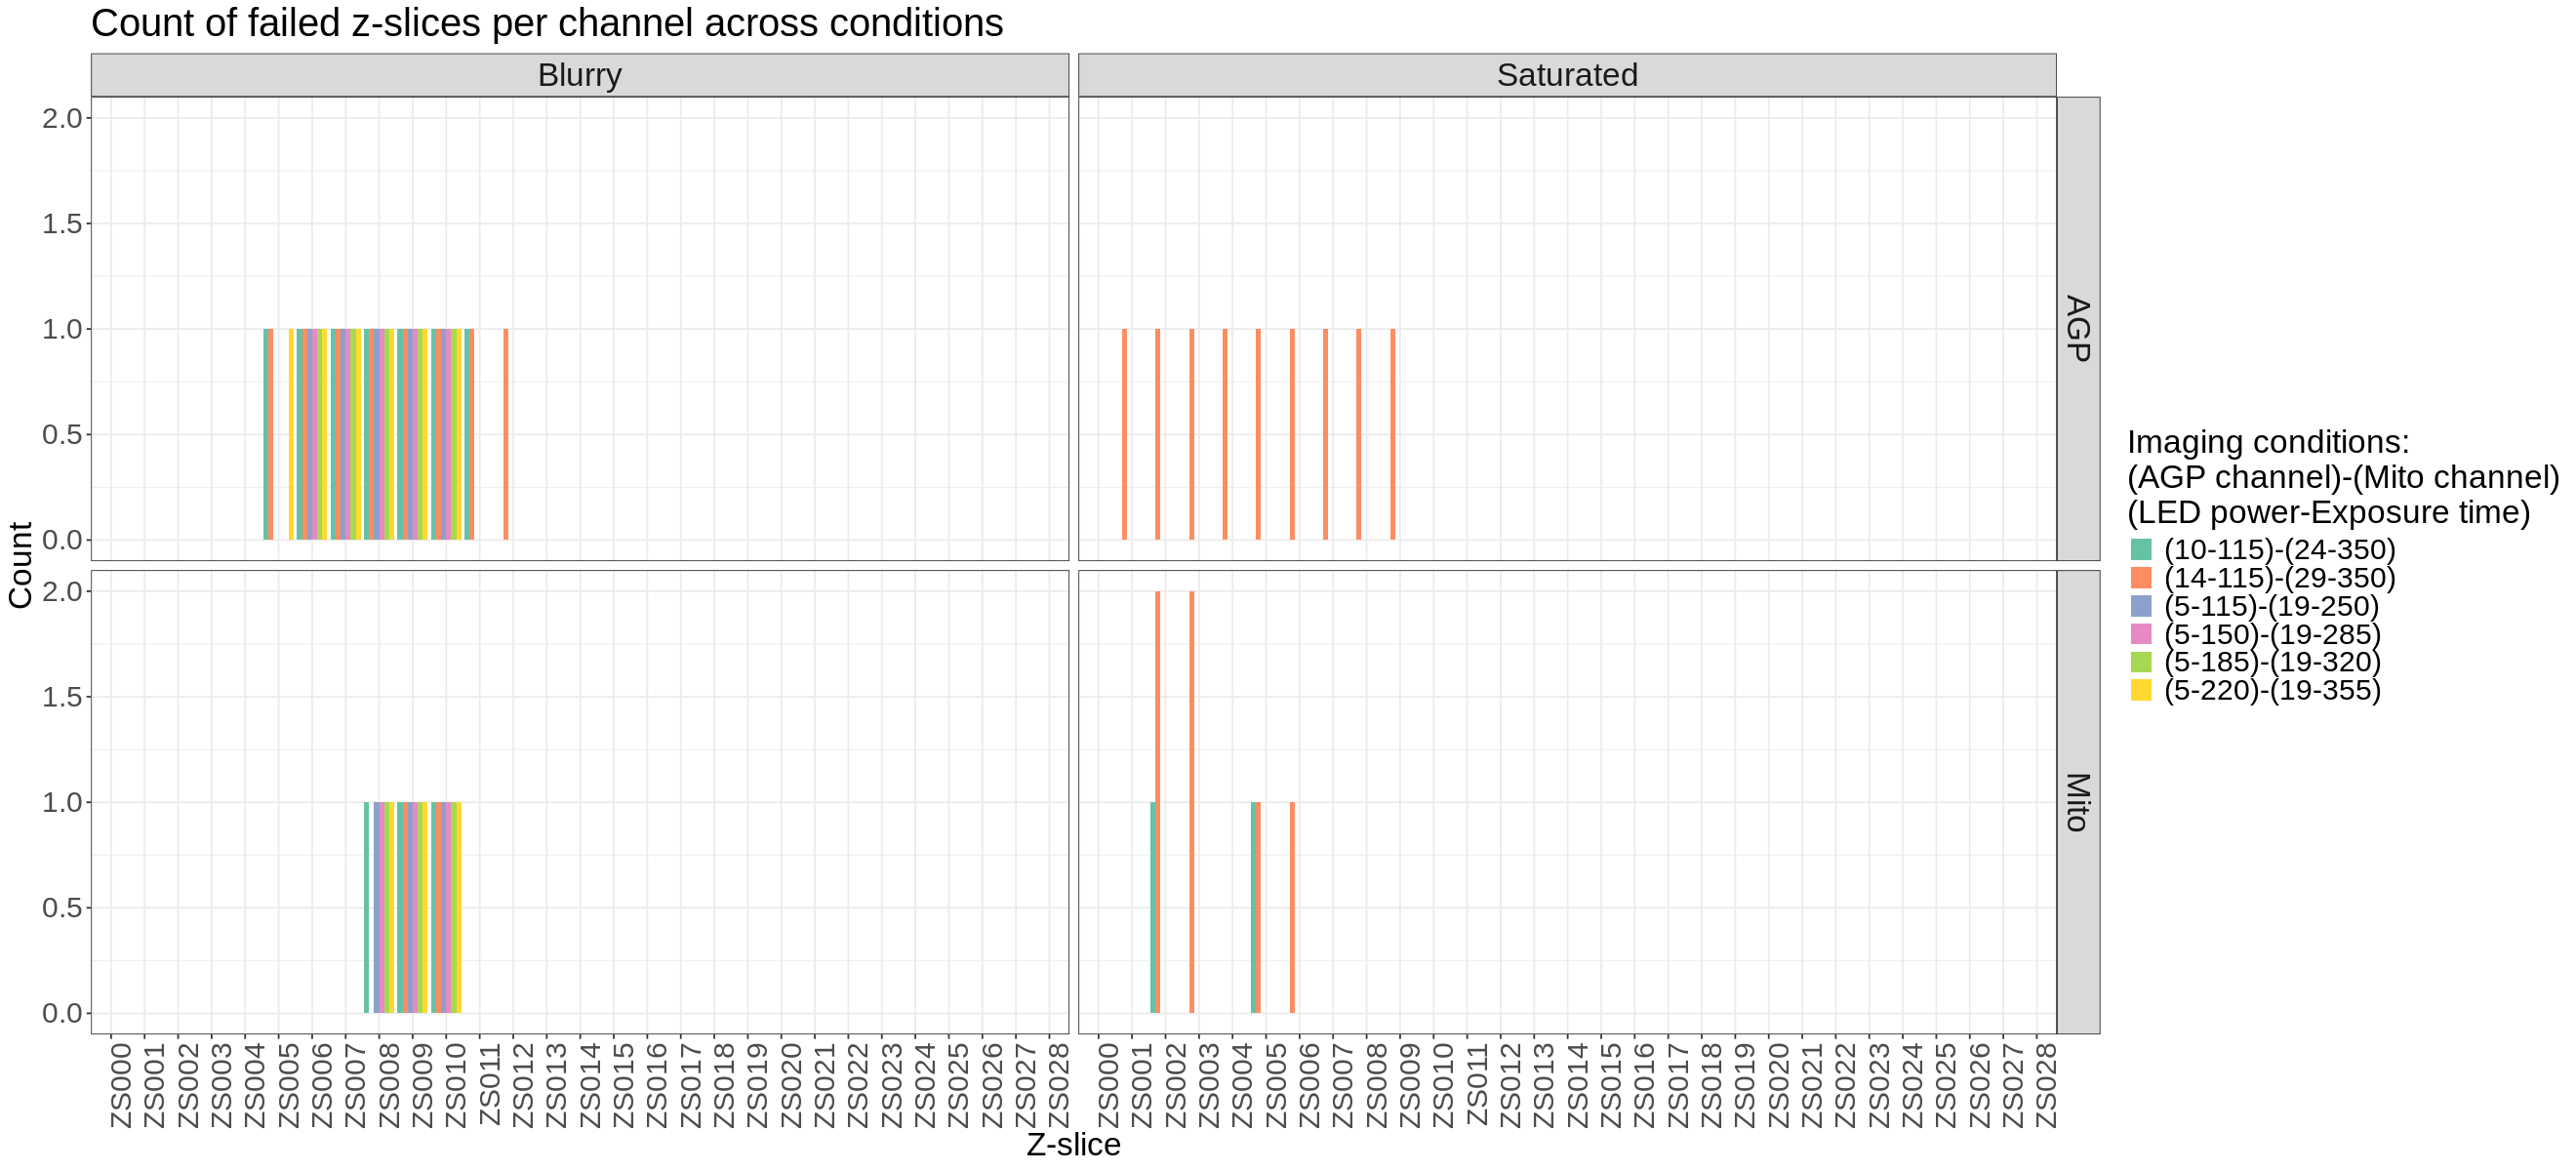

In [9]:
# Calculate the maximum Failed_Count across the entire dataset
max_failed_count <- max(failed_zslices_per_metadata$Failed_Count, na.rm = TRUE)

# Set width and height
width = 22
height = 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot with consistent y-axis limits
bar_plot <- ggplot(failed_zslices_per_metadata, aes(x = Metadata_Zslice, y = Failed_Count, fill = Condition_combo)) +
    geom_bar(stat = "identity", position = "dodge", linewidth = 2) +
    facet_grid(Channel ~ QC_type) +
    scale_fill_brewer(palette = "Set2") +
    labs(
        title = "Count of failed z-slices per channel across conditions",
        x = "Z-slice",
        y = "Count",
        fill = "Imaging conditions:\n(AGP channel)-(Mito channel)\n(LED power-Exposure time)"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18, angle = 90, hjust = 1),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18),
        strip.text = element_text(size = 20)
    ) +
    ylim(0, max_failed_count)
    
# Show plot
print(bar_plot)

# Save plot
ggsave(file.path(figures_dir, "optimization_failed_zslice_count_channel_and_condition.png"), plot = bar_plot, width = width, height = height, dpi = 500)

## Plot the distribution of failed z-slices across normalized z-slice values

By normalizing, we will be able to get a better compare the counts across the z-slices when at the same "level", where 0 still represents the top but 1 now represents the bottom for all organoids.

In [10]:
# Step 1: Remove duplicates for z-slices per organoid (Plate, Well, Site, Zslice, Condition combo)
unique_zslices <- melted_qc_df %>%
    distinct(Metadata_Plate, Metadata_Well, Metadata_Site, Metadata_Zslice, Condition_combo) %>%
    mutate(Numeric_Zslice = as.numeric(gsub("ZS", "", Metadata_Zslice)))

# Step 2: Normalize the z-slices per organoid
normalized_zslices <- unique_zslices %>%
    group_by(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
    mutate(
        Normalized_Zslice = (Numeric_Zslice - min(Numeric_Zslice)) / 
                            (max(Numeric_Zslice) - min(Numeric_Zslice))
    ) %>%
    ungroup()

# Step 3: Join the normalized z-slices back to the original dataframe
norm_melted_qc_df <- melted_qc_df %>%
    left_join(normalized_zslices, by = c("Metadata_Plate", "Metadata_Well", "Metadata_Site", "Metadata_Zslice", "Condition_combo"))

# Step 4: Inspect the result
dim(norm_melted_qc_df)
head(norm_melted_qc_df)

[1] 4728   12

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,AGP_conditions,Mito_conditions,QC_type,Channel,Failed,Condition_combo,Numeric_Zslice,Normalized_Zslice
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>
NF0017,C5,1,ZS000,10-115,24-350,Blurry,Mito,FALSE,(10-115)-(24-350),0,0.0000
NF0017,C5,1,ZS000,10-115,24-350,Blurry,AGP,FALSE,(10-115)-(24-350),0,0.0000
NF0017,C5,1,ZS000,10-115,24-350,Saturated,Mito,FALSE,(10-115)-(24-350),0,0.0000
NF0017,C5,1,ZS000,10-115,24-350,Saturated,AGP,FALSE,(10-115)-(24-350),0,0.0000
NF0017,C5,1,ZS001,10-115,24-350,Blurry,Mito,FALSE,(10-115)-(24-350),1,0.0625
NF0017,C5,1,ZS001,10-115,24-350,Blurry,AGP,FALSE,(10-115)-(24-350),1,0.0625


In [11]:
# Group by Metadata_Zslice, QC_type, Condition_combo, and Channel, then summarize the number of failed zslices
norm_failed_zslices_per_metadata <- norm_melted_qc_df %>%
    group_by(Normalized_Zslice, QC_type, Condition_combo, Channel) %>%
    summarize(Failed_Count = sum(Failed == TRUE, na.rm = TRUE)) %>%  # Explicitly count TRUE values
    ungroup()

# Show dimension and head of the resulting dataframe
dim(norm_failed_zslices_per_metadata)
head(norm_failed_zslices_per_metadata)

`summarise()` has grouped output by 'Normalized_Zslice', 'QC_type',
'Condition_combo'. You can override using the `.groups` argument.


[1] 2040    5

Normalized_Zslice,QC_type,Condition_combo,Channel,Failed_Count
<dbl>,<chr>,<chr>,<chr>,<int>
0,Blurry,(10-115)-(24-350),AGP,0
0,Blurry,(10-115)-(24-350),Mito,0
0,Blurry,(14-115)-(29-350),AGP,0
0,Blurry,(14-115)-(29-350),Mito,0
0,Blurry,(5-115)-(19-250),AGP,0
0,Blurry,(5-115)-(19-250),Mito,0


Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”
Warning message:
“`position_stack()` requires non-overlapping x intervals.”


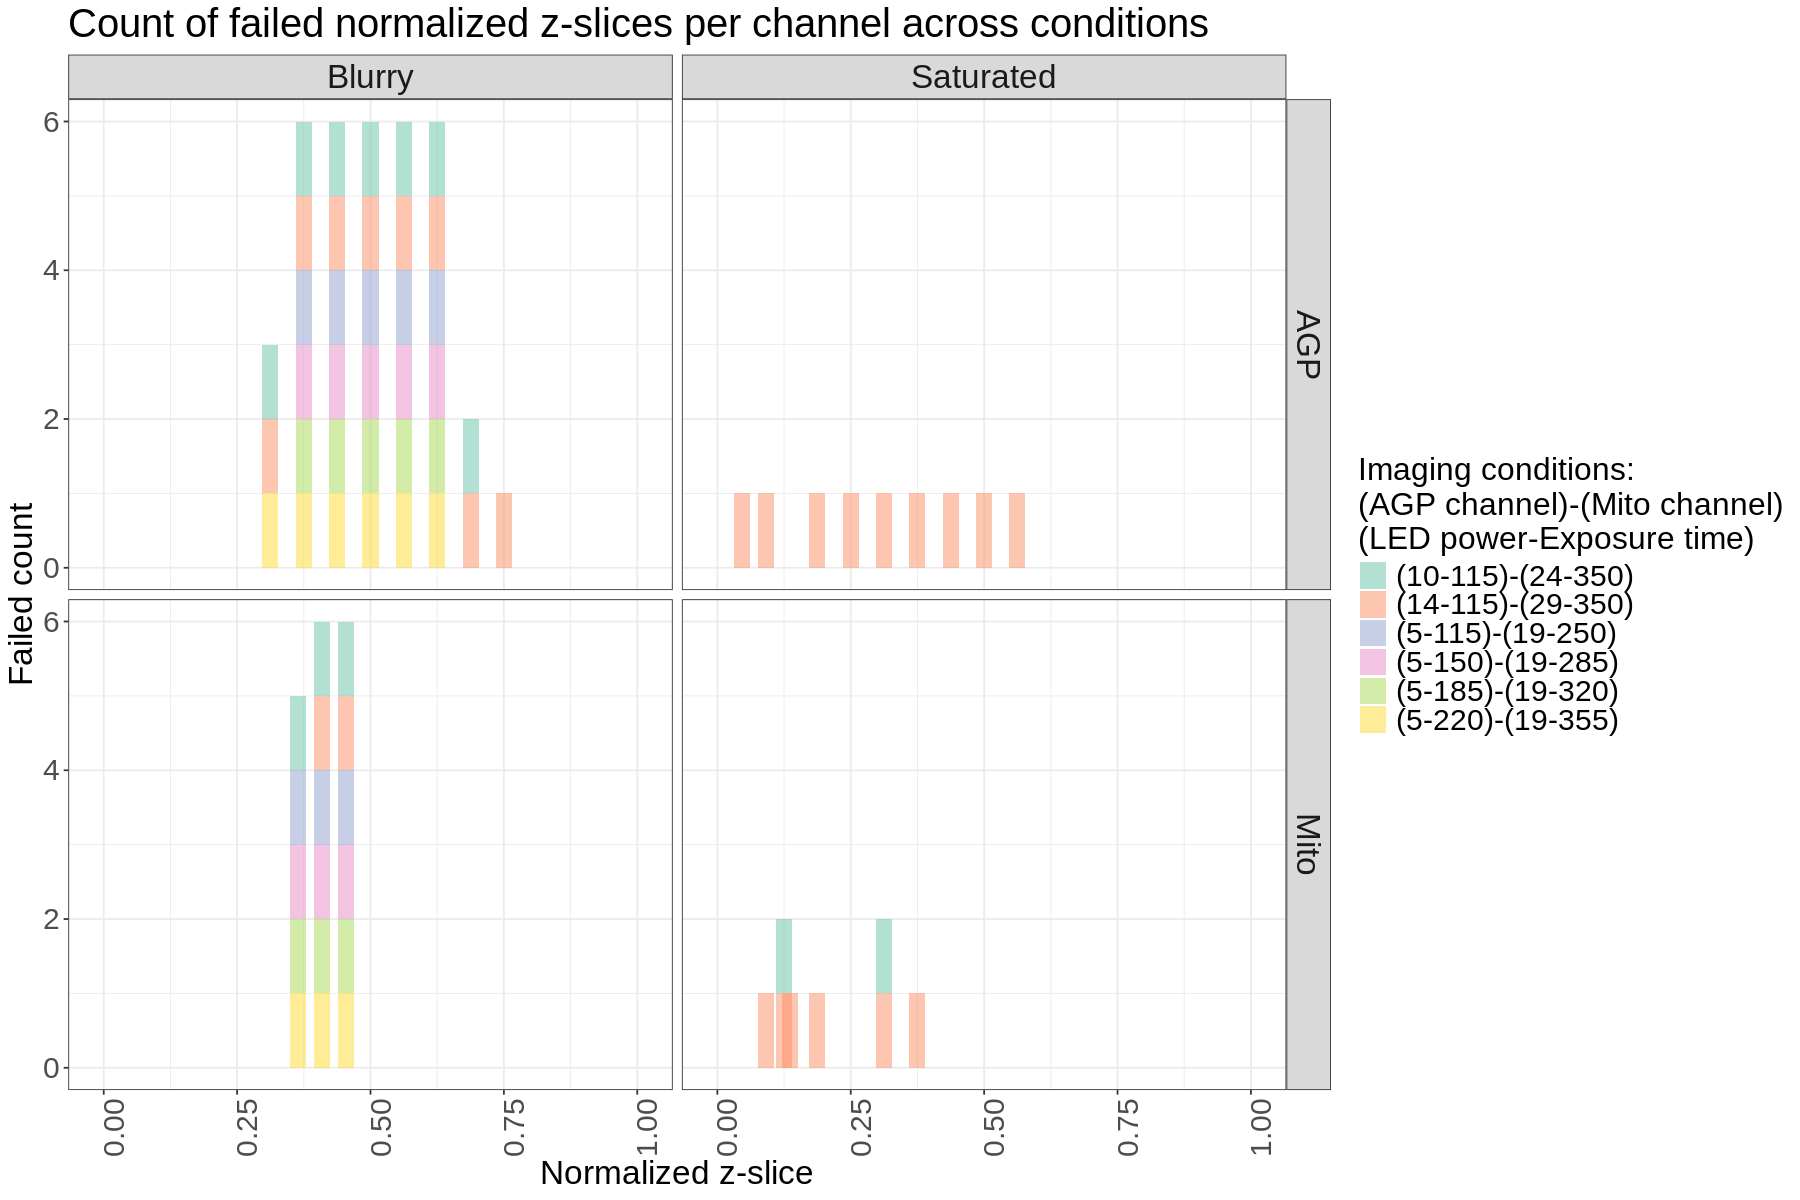

In [12]:
# Set width and height
width <- 15
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot using Failed_Count
histogram_plot <- ggplot(norm_failed_zslices_per_metadata, aes(x = Normalized_Zslice, y = Failed_Count, fill = Condition_combo)) +
    geom_bar(stat = "identity", alpha = 0.5, position = "stack", width = 0.03) +
    facet_grid(Channel ~ QC_type) +
    scale_fill_brewer(palette = "Set2") +
    labs(
        title = "Count of failed normalized z-slices per channel across conditions",
        x = "Normalized z-slice",
        y = "Failed count",
        fill = "Imaging conditions:\n(AGP channel)-(Mito channel)\n(LED power-Exposure time)"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18, angle = 90, hjust = 1),
        legend.title = element_text(size = 19),
        legend.text = element_text(size = 18),
        strip.text = element_text(size = 20)
    )

# Show plot
print(histogram_plot)

# Save plot
ggsave(file.path(figures_dir, "optimization_failed_norm_zslice_count_channel_and_condition.png"), plot = histogram_plot, width = width, height = height, dpi = 500)
